In [1]:
import pandas as pd 
import os

Step -1 Load Dataset

In [ ]:
!ls

drive  sample_data


In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Colab Notebooks/input"

In [2]:
#changing the working directory
%cd "/content/drive/MyDrive/Colab Notebooks/input"
#Check the present working directory using pwd command

/content/drive/MyDrive/Colab Notebooks/input


In [ ]:
!pwd

/content/drive/MyDrive/Colab Notebooks/input


In [ ]:
!kaggle datasets download -d jutrera/stanford-car-dataset-by-classes-folder

100% 1.83G/1.83G [00:19<00:00, 128MB/s]



In [3]:
!ls 

anno_test.csv	car_data     names.csv
anno_train.csv	kaggle.json  stanford-car-dataset-by-classes-folder.zip


In [ ]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

Import libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import time
import os
import PIL.Image as Image
from IPython.display import display

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
Tesla K80


Load dataset and transform

In [5]:
dataset_dir = "../input/car_data/car_data/"

train_tr = transforms.Compose([transforms.Resize((400, 400)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(15),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_tr = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.ImageFolder(root=dataset_dir+"train", transform = train_tr)

trainloader = torch.utils.data.DataLoader(dataset, batch_size = 32, shuffle=True, num_workers = 2)

dataset2 = torchvision.datasets.ImageFolder(root=dataset_dir+"test", transform = test_tr)
testloader = torch.utils.data.DataLoader(dataset2, batch_size = 32, shuffle=False, num_workers = 2)

Model Training Function

In [6]:
def train_model(model, criterion, optimizer, scheduler, n_epochs = 5):
    
    losses = []
    accuracies = []
    test_accuracies = []
   
    model.train()
    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(trainloader, 0):

            
            inputs, labels = data
          
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
                 
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(trainloader)
        epoch_acc = 100/32*running_correct/len(trainloader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        
        model.eval()
        test_acc = eval_model(model)
        test_accuracies.append(test_acc)
        
        
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, test_accuracies

    

Model Evaluation function

In [7]:
def eval_model(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            images, labels = data 
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model_ft(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (
        test_acc))
    return test_acc

In [4]:
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 196)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [9]:
model_ft, training_losses, training_accs, test_accs = train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=5)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1, duration: 1120 s, loss: 3.9281, acc: 16.4093
Accuracy of the network on the test images: 27 %
Epoch 2, duration: 302 s, loss: 1.6105, acc: 58.6642
Accuracy of the network on the test images: 60 %
Epoch 3, duration: 302 s, loss: 0.8414, acc: 77.4142
Accuracy of the network on the test images: 62 %
Epoch 4, duration: 302 s, loss: 0.5120, acc: 85.6985
Accuracy of the network on the test images: 72 %
Epoch 5, duration: 302 s, loss: 0.3512, acc: 89.9510
Accuracy of the network on the test images: 73 %
Finished Training


Text(0.5, 1.0, 'Test acc')

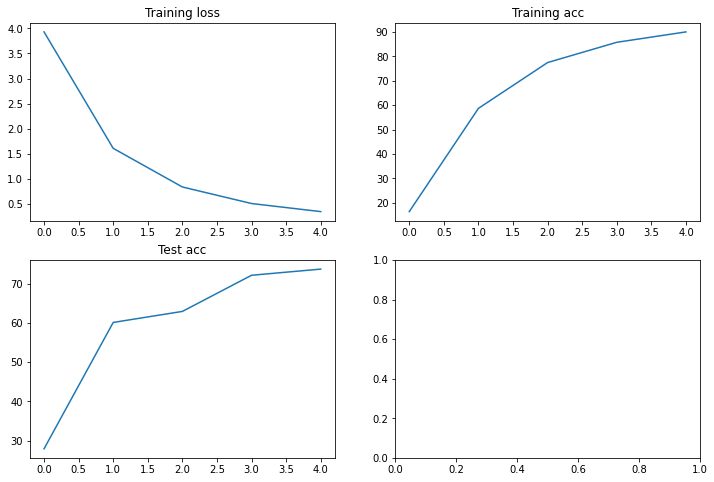

In [10]:
# plot the stats

f, axarr = plt.subplots(2,2, figsize = (12, 8))
axarr[0, 0].plot(training_losses)
axarr[0, 0].set_title("Training loss")
axarr[0, 1].plot(training_accs)
axarr[0, 1].set_title("Training acc")
axarr[1, 0].plot(test_accs)

axarr[1, 0].set_title("Test acc")

In [7]:
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, c_to_idx = find_classes(dataset_dir+"train")

In [12]:
# test the model on random images
dataset_dir = "/content/drive/MyDrive/Colab Notebooks/input/car_data/car_data/"
torch.save(model_ft,"/content/drive/MyDrive/Colab Notebooks/input/car_data/car_data/resnet/model.h5")

model_ft.eval()

# transforms for the input image
loader = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
image = Image.open(dataset_dir+"test/Mercedes-Benz C-Class Sedan 2012/01977.jpg")
image = loader(image).float()
image = torch.autograd.Variable(image, requires_grad=True)
image = image.unsqueeze(0)
image = image.cuda()

output = model_ft(image)
conf, predicted = torch.max(output.data, 1)

In [ ]:
# get the class name of the prediction
display(Image.open(dataset_dir+"test/Mercedes-Benz C-Class Sedan 2012/01977.jpg"))
print(classes[predicted.item()], "confidence: ", conf.item())

In [20]:
# test the model on random images
dataset_dir = "/content/drive/MyDrive/Colab Notebooks/input/car_data/car_data/"
torch.save(model_ft,"/content/drive/MyDrive/Colab Notebooks/input/car_data/car_data/resnet/model.h5")

model_ft.eval()

# transforms for the input image
loader = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
image = Image.open(dataset_dir+ "test/Audi 100 Sedan 1994/00333.jpg")
image = loader(image).float()
image = torch.autograd.Variable(image, requires_grad=True)
image = image.unsqueeze(0)
image = image.cuda()

output = model_ft(image)
conf, predicted = torch.max(output.data, 1)

In [ ]:
# get the class name of the prediction
display(Image.open(dataset_dir+"test/Audi 100 Sedan 1994/00333.jpg"))
print(classes[predicted.item()], "confidence: ", conf.item())